# 协程
协程和生成器本质上都使用了yield关键字，不同的是，协程可以通过send方法传入协程对象以实现某种交互式协作。  
__yield关键字本身可以看作为一种流程控制工具，其作用是调用方（客户端）可以和协程对象进行数据交互，如果不需要客户端传入数据而仅从协程对象拉取数据，协程退化为生成器。__
## 协程实例

In [10]:
def simple_coro2(a):
    print('->Started:a=',a)
    b = yield a
    print('->Received:b=',b)
    c = yield a + b
    print('->Received:c',c)

当程序运行到yield时会将产出的数据返回至调用处，同时接受客户端发回的值：
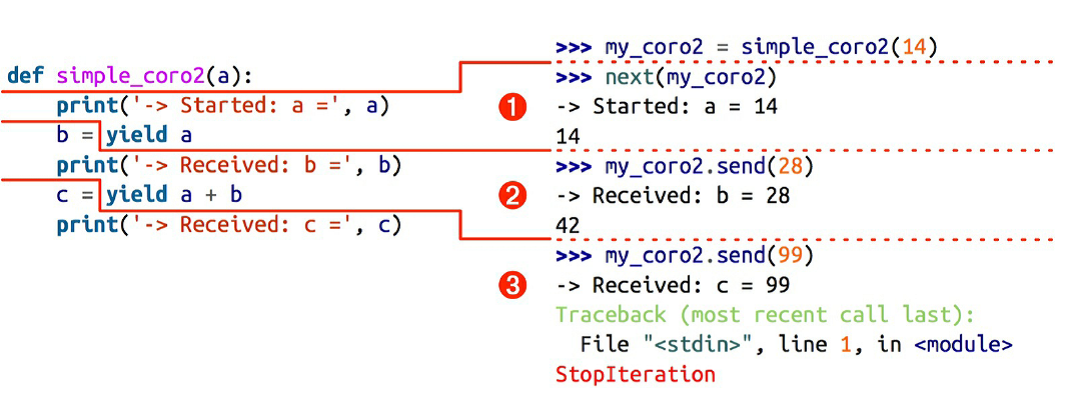
协程对象共有四个状态：  
刚创建时：GEN_CREATED  
运行时：GEN_RUNNING  
暂停时：GEN_SUSPENDED  
结束后：GEN_CLOSED  

In [14]:
from inspect import getgeneratorstate
try:
    my_coro2 = simple_coro2(14)
    print(getgeneratorstate(my_coro2))
    next(my_coro2) # 预激活协程，引起第一次yield，等价于my_co.send(None)
    print(getgeneratorstate(my_coro2))
    my_coro2.send(28)
    print(getgeneratorstate(my_coro2))
    my_coro2.send(99)
finally:
    print(getgeneratorstate(my_coro2))

GEN_CREATED
->Started:a= 14
GEN_SUSPENDED
->Received:b= 28
GEN_SUSPENDED
->Received:c 99
GEN_CLOSED


StopIteration: 

## 生成器与协程的关系.
#### 两者都含有yield表达式，在两种对象上都可以调用send方法，只不过生成器没有接受传入对象的变量而已，等价于gen.send(None)等价于next(gen)。
### 像生成器一样使用协程
下面示例仅仅从协程对象里拉取数据，始终使用next方法，其实相当于send(None),此时的协程对象的行为就是一个生成器对象，可以利用for循环遍历。__因此生成器就是不断send(None)的协程。__

In [51]:
def simple_coroutine():
    print('-> coroutine started')
    x = yield 'start'
    print('-> coroutine received:', x)
    x = yield 'end'
    
my_co = simple_coroutine()
print(my_co.send(None)) # 效果等价于my_co.send(None)
print(next(my_co))
print(next(my_co))

-> coroutine started
start
-> coroutine received: None
end


StopIteration: 

In [20]:
# 等价于上面的代码
for i in simple_coroutine():
    print(i)

-> coroutine started
start
-> coroutine received: None
end


### 像协程一样使用生成器

In [54]:
def simple_generator():
    yield 'start'
    yield 'end'
    
my_gen = simple_generator()
print(next(my_gen))
# 可以给生成器传递值，但生成器无接受传入对象的变量，因此等价于my_gen.send(None)和next(my_gen)。
print(my_gen.send('ali'))

start
end


## 预激协程装饰器
使用协程时每次预激有些麻烦，可以利用预激装饰器

In [1]:
from functools import wraps
from inspect import getgeneratorstate

def coroutine(func):
    @wraps(func) # 含参装饰器，用于使被装饰函数拥有和传入的函数对象有相同的签名（__name__、__doc__属性）。
    def primer(*args, **kwargs):
        gen = func(*args, **kwargs)
        next(gen)
        return gen
    return primer

# 协程版均值处理,无需像闭包那样需要绑定自由变量和nolocal解决局部变量赋值的定义问题。
@coroutine
def averager():
    total = 0.0
    count = 0
    average = None
    while True:
        term = yield average
        total += term
        count += 1
        average = total / count
        
coro_avg = averager()
# 协程对象一开始就是预激活的
print(getgeneratorstate(coro_avg))
print(coro_avg.send(10))
print(coro_avg.send(20))

GEN_SUSPENDED
10.0
15.0


## 终止协程与异常处理
客户端可以在生成器或协程对象上调用方法，显示的将异常发给协程或生成器对象，使其在内部的yield表达式处抛出异常。  
### generator.throw(exc_type[, exc_value[, traceback]])  
异常被传入到yield表达式处再次抛出，如果生成器或协程正确处理该异常，则会运行到下一处yield位置传回生成的值至客户端，否则该异常向上冒泡。__相当于send一个异常给生成器或协程处理。__
### generator.close()
直接传入GeneratorExit异常到yield表达式处再次抛出，如果异常未被处理或是抛出了StopIteration，异常在调用方处停止冒泡而不会报错（__意味着成功使用传入异常的操作终止协程或生成器继续执行，python解释器会阻止异常在调用处继续冒泡，显得像是程序正常运行__），如果生成器或协程正确处理该异常并运行到下一个yield语句，解释器会抛出RuntimError（__本来传递异常是为了让你结束，结果你正常处理了还再次产出值，python解释器会阻止该行为__），

In [11]:
class DemoException(Exception):
    '''演示异常'''
    
def demo_exc_handling():
    print('-> corotine started')
    while True:
        try:
            x = yield
        except DemoException: # 只能处理一种特定异常
            print('DemoException handled, continuing...')
        else:
            print('-> corotine recevied: {!r}'.format(x))
    raise RuntimeError('This line should never run.')
    
co_ro = demo_exc_handling()
next(co_ro)
co_ro.send('start')
co_ro.close()
getgeneratorstate(co_ro)

DemoException handled, continuing...
-> corotine started
-> corotine recevied: 'start'


Exception ignored in: <generator object demo_exc_handling at 0x000001DC4EC271A8>
RuntimeError: generator ignored GeneratorExit


'GEN_CLOSED'

#### generator.close()不是简单的执行generator.throw(GeneratorExit())，额外添加了两种行为：  
1.当GeneratorExit或StopIteration异常由生成器或协程冒泡时（生成器或协程未能处理）调用端不会报错  
2.当GeneratorExit被传入，而生成器或协程继续yield下一个值时会被python解释器制止（抛出RuntimeError）

In [9]:
co_ro = demo_exc_handling()
next(co_ro)
co_ro.send('start')
co_ro.throw(DemoException())
co_ro.throw(GeneratorExit()) # 不会像执行close方法那样，这里客户端（调用处）会继续抛出生成器或协程无法处理的GeneratorExit异常

-> corotine started
-> corotine recevied: 'start'
DemoException handled, continuing...


GeneratorExit: 

## yield from
yield from是全新的语言结构，第14章提过它可以替代for循环和yield结构：

In [16]:
def gen():
    for c in 'AB':
        yield c
    for i in 'CD':
        yield i

# 等价于
def gen1():
    yield from 'AB'
    yield from 'CD'
    
print(list(gen()))
print(list(gen1()))

['A', 'B', 'C', 'D']
['A', 'B', 'C', 'D']


yield from首先获取对象的迭代器，iter(x),因此yield from可用于任意可迭代对象（实现了\__iter__协议），__另外其最主要的作用是打开双向通道，在最外层调用和最内层协程或生成器对象之间建立双向通道，使得最外层直接与最内层协程或生成器进行交互，程序的运行变成了最外成客户端与最内层子生成器间的交互，这实际上避免编写大量的提供中间管道功能的样板代码。__  
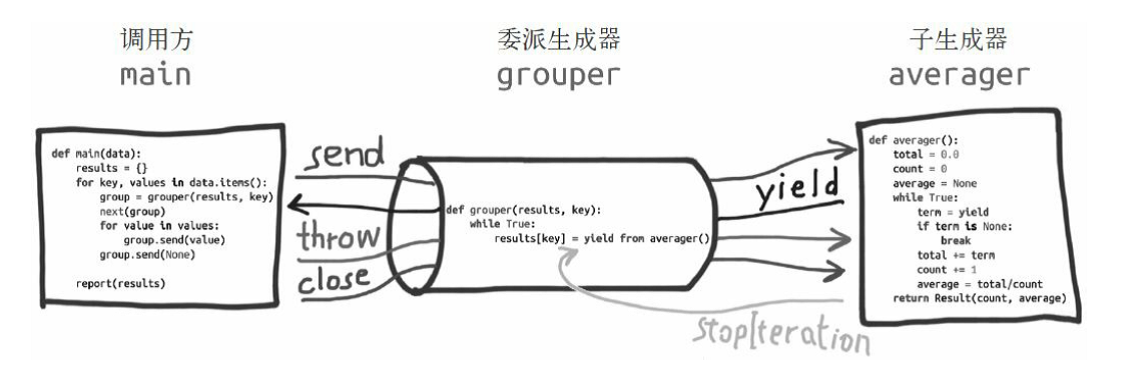

下面通过示例讲解，在此之前明确几个关键术语：  


__客户端__：即最外层的调用方。  
__委派生成器__：即含有yield from语句的函数。  
__子生成器__：yield from表达式后面的__任意可迭代对象__。

In [28]:
from collections import namedtuple

Result = namedtuple('Result', 'count average')

# 子生成器(协程),当协程结束时可返回值
def averager():
    total = 0.0
    count = 0
    average = None
    while True:
        term = yield average
        # 客户端发来None哨符会导致子生成器返回与结束（同时抛出Stopiteration）
        if term is None:
            break
        total += term
        count += 1
        average = total / count
    return Result(count, average)

# 委派生成器
def grouper(results, key):
    # averager子生成器终止后yield from才能结束并返回值，同时该委派生成器被再次激活随后结束运行（仅有一次yield from），同时抛出Stopiteration
    results[key] = yield from averager()
        
# 客户端
def main(data):
    results = {}
    # 遍历数据集
    for key, values in data.items():
        group = grouper(results, key) # 每个数据集的均值统计都会创建一个委派生成器。
        next(group) # 预激
        for value in values:
            # 这里用委派生成器send过去的值会直接由子生成器或协程接收到，也就是averager中的term接收该值（同时子生成器返回None）
            group.send(value)
        try:
            # 该行会导致自生成器或协程接受None，意味着term为None，导致averager子生成器结束并返回结果（同时抛出Stopiteration）
            # 另一方面，yield from会处理子生成器的Stopiteration，并将得到的返回值返回，此时yield from结束，程序控制权移交至委派生成器下一行。
            group.send(None)
        # 子生成器的结束会导致委派生成器结束而抛出Stopiteration，这里需处理
        except StopIteration:
            continue
        
    report(results)
    
# 输出报告
def report(results):
    for key, result in sorted(results.items()):
        group, unit = key.split(';')
        print('{:2} {:5} averaging {:.2f}{}'.format(result.count, group, result.average, unit))
        
data = {'girls;kg':[40.9, 38.5, 44.3, 42.5, 45.2, 41.7, 44.5, 38, 40.6, 44.5],
       'girls;m':[1.6, 1.51, 1.4, 1.3, 1.41, 1.39, 1.33, 1.46, 1.45, 1.43],
       'boys;kg':[39, 40.8, 43.2, 40.8, 43.1, 38.6, 41.4, 40.6, 36.3],
       'boys;m':[1.38, 1.5, 1.32, 1.25, 1.37, 1.48, 1.25, 1.49, 1.46]}

if __name__ == '__main__':
    main(data)

 9 boys  averaging 40.42kg
 9 boys  averaging 1.39m
10 girls averaging 42.07kg
10 girls averaging 1.43m


# yield from运作具体流程
yield from本身有较为复杂的特性，它连接了外部调用方与内部子生成器，同时还能处理子生成器仅是普通可迭代对象以及需要像一般协程或生成器那样包含调用方向子生成器throw异常或发送close指令这样的功能。理解yield from的行为需要研究其实现逻辑。这里列出下面一行代码的背后执行逻辑:
#### RESULT = yield from EXPR
__yield from简化版__，仅处理EXPR为生成器对象的情况（必须有send方法），不支持传递客户端利用委派生成器对象发送的异常（调用throw）和close指令（调用close）给子生成器，仅处理子生成器结束时抛出Stopiteration异常的情况。

In [ ]:
EXPR = averager()
_i = iter(EXPR)

try:
    _y = next(_i) # 预激子生成器，获取子生成器初始值，然后子生成器挂起。
except StopIteration as _e:
    RESULT = _e.value
else:
    while True:
        _s = yield _y # 委派生成器核心逻辑1：将子生成器结果传出后委派生成器挂起，等待客户端传入值并赋值给_s。
        try:
            _y = _i.send(_s) # 委派生成器核心逻辑2：将客户端传入的值_s并调用send方法传递给子生成器，子生成器被激活。
        except StopIteration as _e:
            RESULT = _e.value
            break

__yield from完全版__，支持将客户端利用委派生成器传入的throw异常，或close指令，传递给子生成器的功能，同时当客户端send(None)时，委派生成器的yield from能自动优化为对子生成器使用next方法（send(None)相当于不传值，只拉取值）

In [ ]:
EXPR = averager()
_i = iter(EXPR)

try:
    _y = next(_i) # 预激子生成器，获取子生成器初始值，然后子生成器挂起。
except StopIteration as _e:
    RESULT = _e.value
else:
    while True:
        try:
            _s = yield _y # 委派生成器核心逻辑1：将子生成器结果传出后委派生成器挂起，等待客户端传入值并赋值给_s。
        except GeneratorExit as _e: # 捕获客户端传入的GeneratorExit（可能是客户端调用委派生成器的close方法，也可能是throw方法）
            try:
                _m = _i.close
            except AttributeError:
                pass
            else:
                _m() # 由子生成器执行close方法，非正常关闭时会正常异常冒泡（Stopiteration会被无视）
            raise _e # yield from抛出传入的GeneratorExit异常（如果客户端使用close则在客户端不会报错，若为throw则异常能在客户端继续冒泡）。
        except BaseException as _e: # 捕获出入的其他类型异常（只可能是客户端调用委派生成器的throw方法）
            try:
                _m = _i.throw
            except AttributeError:
                raise _e # 如果子生成器无法接收异常，yield from必须抛出该异常。
            else:
                try: # 但凡子生成器再次激活的地方都要捕获StopIteration
                    _y = _m(*sys.exc_info()) # 由子生成器执行throw方法，如果子生成器捕获了该异常，委派生成器无需再次抛出。
                except StopIteration as _e:
                    RESULT = _e.value
                    break
        else:
            try: # 委派生成器核心逻辑2：将客户端传入的值_s并调用send方法传递给子生成器，子生成器被激活。
                if _s is None: # 如果send(None)则直接从子生成器_i拉取数据，这样便能支持无send方法的可迭代对象。
                    _y = next(_i) 
                else:
                    _y = _i.send(_s) 
            except StopIteration as _e:
                RESULT = _e.value
                break

### yield from需要注意的几点
#### 一 .yield from通过将客户端传递给委派生成器的异常重新移交给子生成器完成异常传递 
1.针对GeneratorExit异常，委派生成器yield from语句调用子生成器的close方法传递异常，同时yield from一定要再次抛出该异常，因为如果客户端通过throw传递该异常，即便子生成器正常close(),委派生成器的yield from也得将不能处理的异常抛出（符合throw的行为）。如果该异常通过客户端调用close传递进来，那么如果子生成器正常close()，GeneratorExit在客户端处不会报错，意味着正常结束（符合close的行为）。

2.针对其他传递给委派生成器的异常，一定是客户端通过委派生成器的throw方法传递，那么只要子生成器能处理该异常，yield from就无需再抛出该异常（符合throw的行为）。
#### 二.yield from要支持所有可迭代对象
yield from可能用于没有send方法的非生成器或协程的可迭代对象，这种情况下客户端会直接通过委派生成器调用send(None)或next(grouper)（相当于send(None)）,yield需要针对这种情况在该可迭代对象上调用next方法，如果此时客户端send非None参数，应当产生EXPR无send方法的异常。
#### 三.yield from有预激子生成器的操作，因此不可对其使用预激装饰器

## yield from用于非生成器可迭代对象
#### 以之前的gen1方法为例，也可以拆解出客户端、委派生成器、子生成器三个角色，gen1为委派生成器，其中有两个子生成器，分别为可迭代的字符串'AB'和'CD'。

在客户端（外部调用处）调用send(None)（相当于调用next方法）便可与最内部的子生成器实现交互，__不过由于子生成器仅是普通的可迭代对象而无法像生成器一样含有yield表达式能接收值，因此外部客户端只能使用send(None)或next方法来迭代获取子生成器的元素。__

In [1]:
# 委派生成器
def gen1():
    yield from 'AB'
    yield from 'CD'
    
grouper = gen1()
print(grouper.send(None))
print(next(grouper))
print(grouper.send(None))
print(grouper.send(None))
print(grouper.send(None))

A
B
C
D


StopIteration: 

## 使用协程做离散仿真
协程天然的交互性模型结构，方便用于模拟一个与外界交互的事件流程，外界可通过发送指令驱动协程的执行，用协程表示一个事件进程的运行是合适的选择

In [ ]:
import queue
from collections import namedtuple

Event = namedtuple('Event', 'time id event')

# 事件模拟协程：出租车运行协程
def taxi_process(ident, trips, start_time=0):
    time = yield Event(start_time, ident, 'leave garage') # 产生出租车的首次发生事件：离开车库
    for i in range(trips): # 主事件流程循环
        time = yield Event(time, ident, 'pick up passenger')
        time = yield Event(time, ident, 'drop off passenger')
    yield Event(time, ident, 'going home') # 产生出租车的最后发生事件：回家
    
# 仿真调度程序
class Simulator:
    def __init__(self, procs_map):
        self.event = queue.PriorityQueue() # 优先级队列
        self.procs = dict(procs_map) # 创建浅拷贝副本
        
    def run(self, end_time):
        # 初始化事件优先级队列（事件时间）, 预激活每个出租车仿真协程并得到对应初始事件
        for _, proc in sorted(self.procs.items()):
            self.event.put(next(proc))
            
        # 主循环
        sim_time = 0
        while sim_time < end_time:
            if self.event.empty():
                print("*** end of events ***")
                break
            
            current_event = self.event.get() # 获取优先级最高的（时间最小的）实践为当前发生的离散事件
            sim_time, proc_id, action = current_event
            print('taxi:', proc_id, current_event)
            active_proc = self.procs[proc_id] # 获取当前事件对应的协程对象
            next_time = simu_time + compute_duration(action) # 利用当前事件给出对应下次模拟事件发生的时间
            try:
                next_event = active_proc.send(next_time) # 利用对应协程获取下次仿真的事件（传入其发生时间）
            except StopIteration:
                del self.procs[proc_id] # 删除结束的仿真协程，队列中不会有该协程的任何事件对象了（最后的事件已被取出）
            else:
                self.event.put(next_event) # 将下次事件放入队列，下次被取出时才是该事件真正发生的时间
        else:
            msg = '*** end of simulation time: {} events pending ***'
            print(msg.format(self.event.qsize()))
            
if __name__ == '__main__':
    taxis_procs = {0: taxi_process(ident=0, trips=2, start_time=0),
                   1: taxi_process(ident=0, trips=4, start_time=5),
                   2: taxi_process(ident=0, trips=6, start_time=10)}
    simu = Simulator(taxis_procs)
    simu.run(30) # 模拟30秒的运行